# **Behavioral Cloning**

## Install & Import packages/libraries

In [ ]:
# READ INSTRUCTIONS!!!
# 1) RUN THIS CELL
# 2) DRINK SOME COFFEE WHILE DOWNLOADING PACKAGES... (around 1~2 minutes)
# 3) CLICK ON RESTART RUNTIME BUTTON
# 4) RUN THIS CELL, AGAIN
# ****REMEMBER TO RESTART RUNTIME AFTER RUNNING THIS CELL!
!apt-get update

!pip install gym
!git clone https://github.com/jakevdp/JSAnimation
%cd JSAnimation
!python setup.py install

!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install pyglet
!pip install matplotlib==2.0
%cd ..

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [68.5 kB]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:8 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:12 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:13 https://developer.download.nvi

/content


In [17]:
from IPython.display import HTML, display
from gym.wrappers import Monitor
import base64
import glob
import io

from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import numpy as np
import pickle
import gzip
import gym
%matplotlib inline

def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display(HTML(data='''<video alt="test" autoplay
                     loop controls style="height: 400px;">
                     <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                     </video>'''.format(encoded.decode('ascii'))))
    else:
        print('No video found.')

def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env

## MountainCar Visualization

Information on "MountainCarContinuous-v0" gym environment: <br>
[github.com/openai/gym/wiki/MountainCarContinuous-v0](https://github.com/openai/gym/wiki/MountainCarContinuous-v0)

In [18]:
# Get environment information
env_name = "MountainCarContinuous-v0"
env = gym.make(env_name)

obs_space = env.observation_space
print('observation space: {}'.format(obs_space))
print('dimension: {}'.format(obs_space.shape[0]))
print('high: {}'.format(obs_space.high))
print('low: {}\n'.format(obs_space.low))

action_space = env.action_space
print('action space: {}'.format(action_space))
print('dimension: {}'.format(action_space.shape[0]))
print('high: {}'.format(action_space.high))
print('low: {}\n'.format(action_space.low))

observation space: Box(-1.2000000476837158, 0.6000000238418579, (2,), float32)
dimension: 2
high: [0.6  0.07]
low: [-1.2  -0.07]

action space: Box(-1.0, 1.0, (1,), float32)
dimension: 1
high: [1.]
low: [-1.]



In [19]:
# Initialize virtual display
from pyvirtualdisplay import Display
Display().start()

In [20]:
# Visualize gym environment
env = wrap_env(gym.make(env_name))
obs = env.reset()
total_reward = 0

for t in range(100):
    action = env.action_space.sample() # Random action
    # Try inserting values by uncommenting the following line to see what each action value performs! [-1.0, 1.0]
    #action = np.array([1.0])
    obs, reward, done, info = env.step(action)
    # Render environment to virtual display
    env.render(mode='rgb_array')
    total_reward += reward
    if done: # done becomes true when environment terminates
        break

env.close()
print('Total Reward: {:.2f}'.format(total_reward))
show_video()

Total Reward: -3.66


## MountainCar Expert Behavior

In [21]:
# Remember to upload "MountainCarContinuous-v0_expert.pkl"!
# We will now visualize how an expert's policy on the environment

env_name = "MountainCarContinuous-v0"

# Load demonstrations
with open('./' + env_name + '_expert_demo.pkl', 'rb') as f:
    demos = pickle.load(f)[0]
demos = shuffle(demos)
print("Number of expert demonstrations: {}".format(len(demos)))
print("Available information on each demonstration", list(demos[0].keys()))
print("Dimensions on components of first demonstration")
print("Rewards: {}".format(demos[0]['rewards'].shape))
print("Actions: {}".format(demos[0]['actions'].shape))
print("Infos: {}".format(len(demos[0]['infos'])))
print("Observes: {}".format(demos[0]['observes'].shape))
# Check expert's performance
exp_ret = np.mean([np.sum(d['rewards']) for d in demos])
print("Expert's Average Cumulative Rewards: {:.3f}".format(exp_ret))

Number of expert demonstrations: 100
Available information on each demonstration ['rewards', 'actions', 'infos', 'observes']
Dimensions on components of first demonstration
Rewards: (392,)
Actions: (392, 1)
Infos: 392
Observes: (392, 2)
Expert's Average Cumulative Rewards: 92.459


In [22]:
# Gather the demonstrations' observations and actions
demo_observations = []
demo_actions = []
for demo in demos:
    for t_idx in range(len(demo['observes'])):
        demo_observations.append(demo['observes'][t_idx])
        demo_actions.append(demo['actions'][t_idx])

# Convert lists into numpy arrays
demo_observations = np.asarray(demo_observations)
demo_actions = np.asarray(demo_actions)

# Shuffle data to break correlation
demo_observations, demo_actions = shuffle(demo_observations, demo_actions)

# Check number of demonstrations!
print("Total number of demonstrations: {}".format(len(demo_actions)))

# Use only first 100 demos for simplicity
demo_observations = demo_observations[:100, :]
demo_actions = demo_actions[:100, :]

# Print observation and action dimensions
print("Observation data: {}".format(demo_observations.shape))
print("Action data: {}".format(demo_actions.shape))

Total number of demonstrations: 41035
Observation data: (100, 2)
Action data: (100, 1)


## Gaussian Process Regression

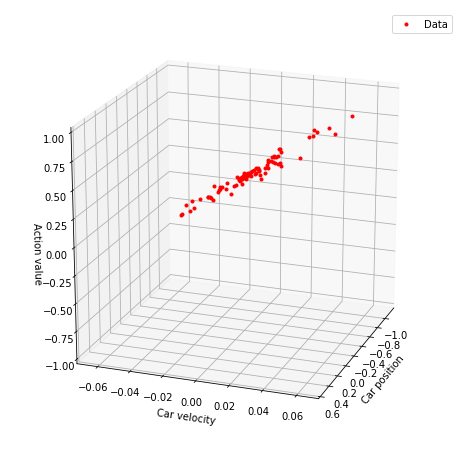

In [23]:
# Visualize data points
from mpl_toolkits.mplot3d import Axes3D
x = demo_observations[:, 0] # position
y = demo_observations[:, 1] # velocity
z = demo_actions[:, 0] # actions value

def plot_3d(x, y, z, angle1=30, angle2=30):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca(projection='3d')
    ax.plot3D(x, y, z, 'r.', label='Data')
    plt.legend()
    ax.set_xlabel('Car position')
    ax.set_ylabel('Car velocity')
    ax.set_zlabel('Action value')
    ax.set_xlim3d(-1.2, 0.6)
    ax.set_ylim3d(-0.07, 0.07)
    ax.set_zlim3d(-1., 1.) # action value space
    ax.view_init(angle1, angle2)
    plt.show()

plot_3d(x, y, z, 20, 20)

In [24]:
# We will use GPR to learn from these expert demonstrations by setting them as targets!
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

init_lambda = 10.0
init_beta = 2.0
init_sigma = 0.04

kernel = ConstantKernel(init_beta, (1e-3, 1e3)) * RBF(init_lambda, (1e-3, 1e3))
gp = GaussianProcessRegressor(kernel=kernel, alpha=init_sigma, n_restarts_optimizer=9)

####### TO IMPLEMENT #########
demo_obs_mean = np.mean(demo_observations, axis=0, keepdims=True)
demo_obs_std = np.std(demo_observations, axis=0, keepdims=True)
# Remember, we offset values by the mean since we assume the Gaussian process has 0 mean! Here we also normalize by std values.
nz_demo_observations = (demo_observations - demo_obs_mean) / demo_obs_std
##############################

gp.fit(nz_demo_observations, demo_actions)

GaussianProcessRegressor(alpha=0.04, copy_X_train=True,
                         kernel=1.41**2 * RBF(length_scale=10),
                         n_restarts_optimizer=9, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)

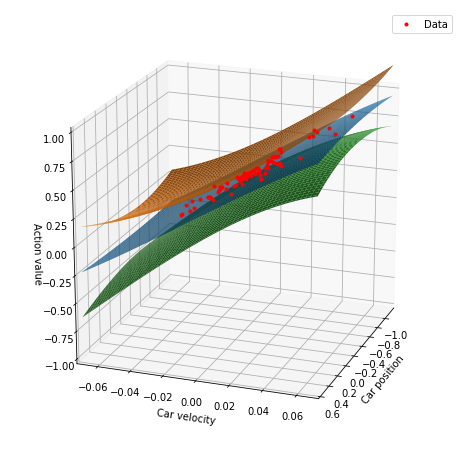

In [25]:
# Visualize learned GPR
def plot_GPR_3d(x, y, z, gp, mean, std, angle1=30, angle2=30, show_CI=True):
    x1 = np.linspace(-1.2, 0.6, 100).reshape(-1, 1)
    x2 = np.linspace(-0.07, 0.07, 100).reshape(-1, 1)
    X1, X2 = np.meshgrid(x1, x2)
    XX = np.concatenate([X1.reshape(-1, 1), X2.reshape(-1, 1)], axis=1)
    XX = (XX - mean) / std
    YY = np.zeros((100, 100))
    if show_CI is True:
        YY_upper = np.zeros((100, 100))
        YY_lower = np.zeros((100, 100))
    for i in range(100):
        for j in range(100):
            idx = i*100 + j
            YY_mean, YY_std = gp.predict(XX[idx].reshape(-1, 2), return_std=True)
            YY[i, j] += YY_mean
            if show_CI is True:
                YY_upper[i, j] += YY_mean + 1.96*YY_std
                YY_lower[i, j] += YY_mean - 1.96*YY_std
    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca(projection='3d')
    ax.plot3D(x, y, z, 'r.', label='Data')
    ax.plot_surface(X1, X2, YY)
    if show_CI is True:
        ax.plot_surface(X1, X2, YY_upper)
        ax.plot_surface(X1, X2, YY_lower)
    plt.legend()
    ax.set_xlabel('Car position')
    ax.set_ylabel('Car velocity')
    ax.set_zlabel('Action value')
    ax.set_xlim3d(-1.2, 0.6)
    ax.set_ylim3d(-0.07, 0.07)
    ax.set_zlim3d(-1., 1.) # action value space
    ax.view_init(angle1, angle2)
    plt.show()

plot_GPR_3d(x, y, z, gp, demo_obs_mean, demo_obs_std, 20, 20, show_CI=True)

In [26]:
# Initialize virtual display
from pyvirtualdisplay import Display
Display().start()

In [27]:
# Visualize cloned behavior
env = wrap_env(gym.make(env_name))
obs = env.reset()
total_reward = 0

for t in range(10000):
    obs = np.reshape(obs, [1, -1])
    ############# TO IMPLEMENT ################
    nz_obs = (obs - demo_obs_mean) / demo_obs_std
    action = gp.predict(nz_obs)
    ###########################################
    obs, reward, done, info = env.step(action)
    # Render environment to virtual display
    env.render(mode='rgb_array')
    total_reward += reward
    if done: # done becomes true when environment terminates
        break

env.close()
print('Total Reward: {:.2f}'.format(total_reward))
show_video()

Total Reward: 88.43


***TO THINK ABOUT<br>
Can we use value iteration on this environment?
Why or why not?